# Implémentez un modèle de scoring

## Import

In [21]:
# Classique
import pandas as pd
import numpy as np
import re
import joblib
import time

# Visu
import missingno as msno
import seaborn as sns
import matplotlib. pyplot as plt

# utils
import utils

# MLFlow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

# Sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_classif, VarianceThreshold

## Data

In [22]:
df_app = pd.read_csv('Data/application_train.csv')

### Aperçu des données

Check des valeurs manquantes, duplicata, type et dimension de nos données

In [23]:
df_app.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

<AxesSubplot: >

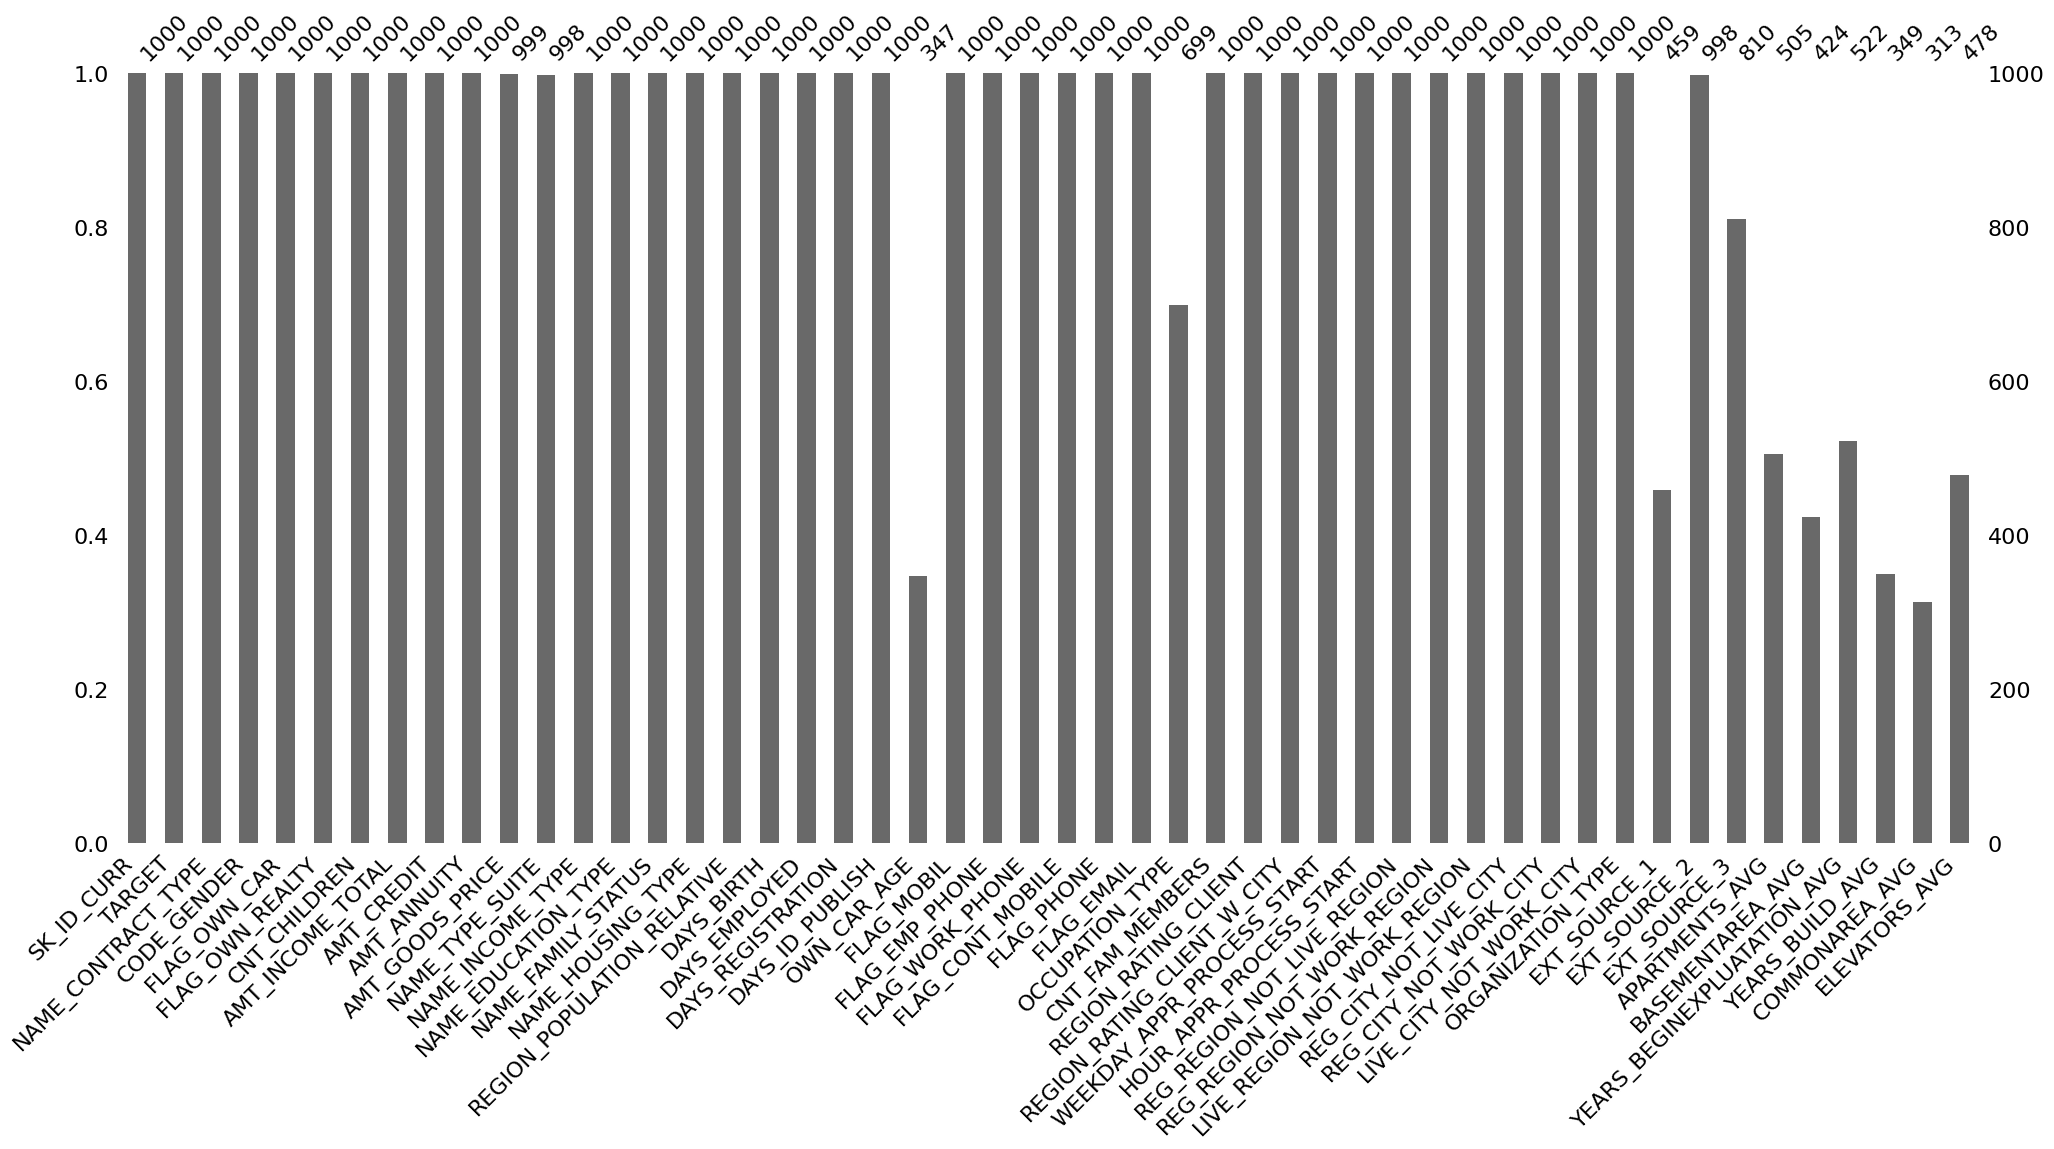

In [24]:
msno.bar(df_app.iloc[:, 0:50].sample(1000))

<AxesSubplot: >

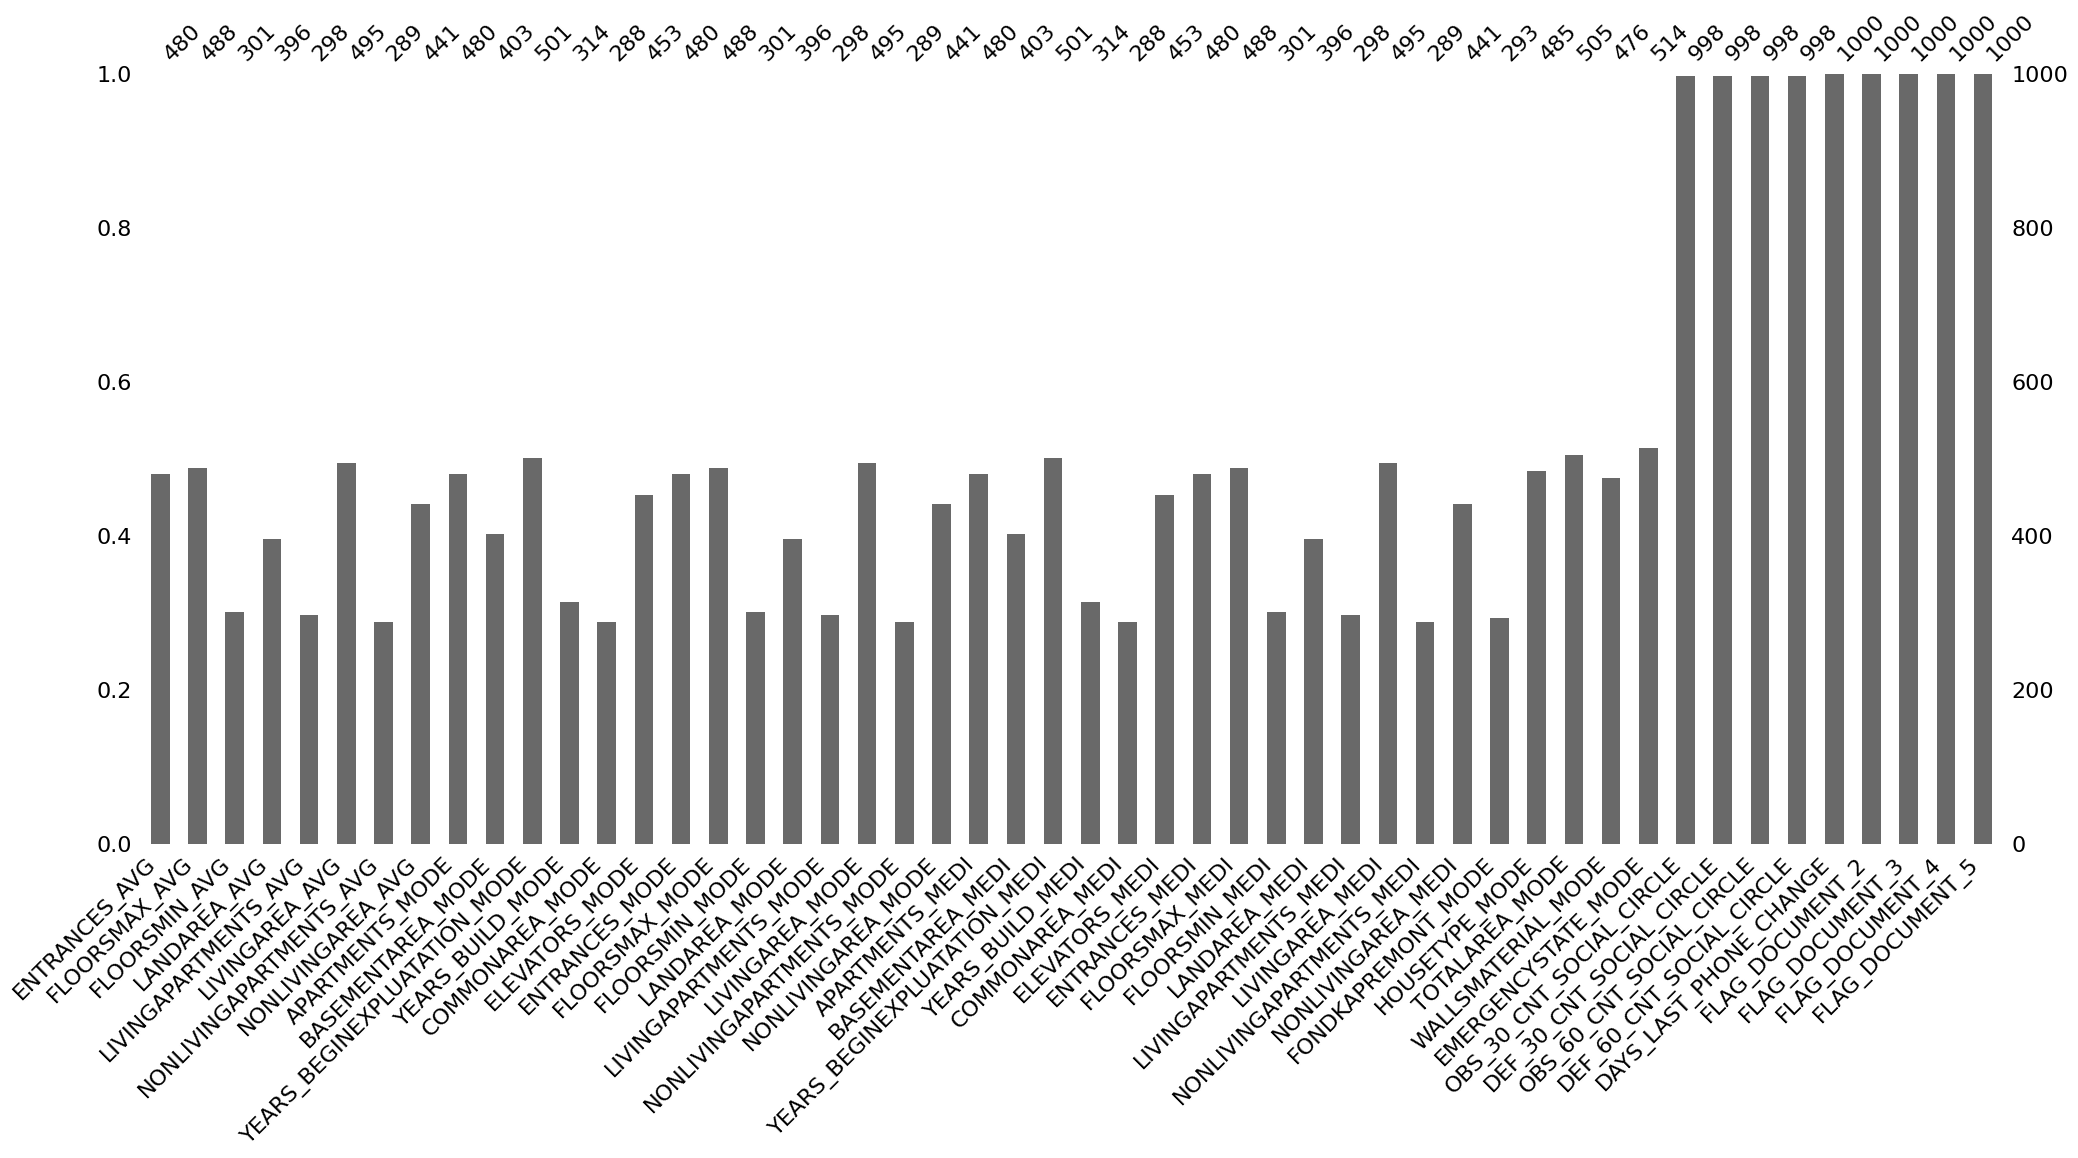

In [25]:
msno.bar(df_app.iloc[:, 50:100].sample(1000))

<AxesSubplot: >

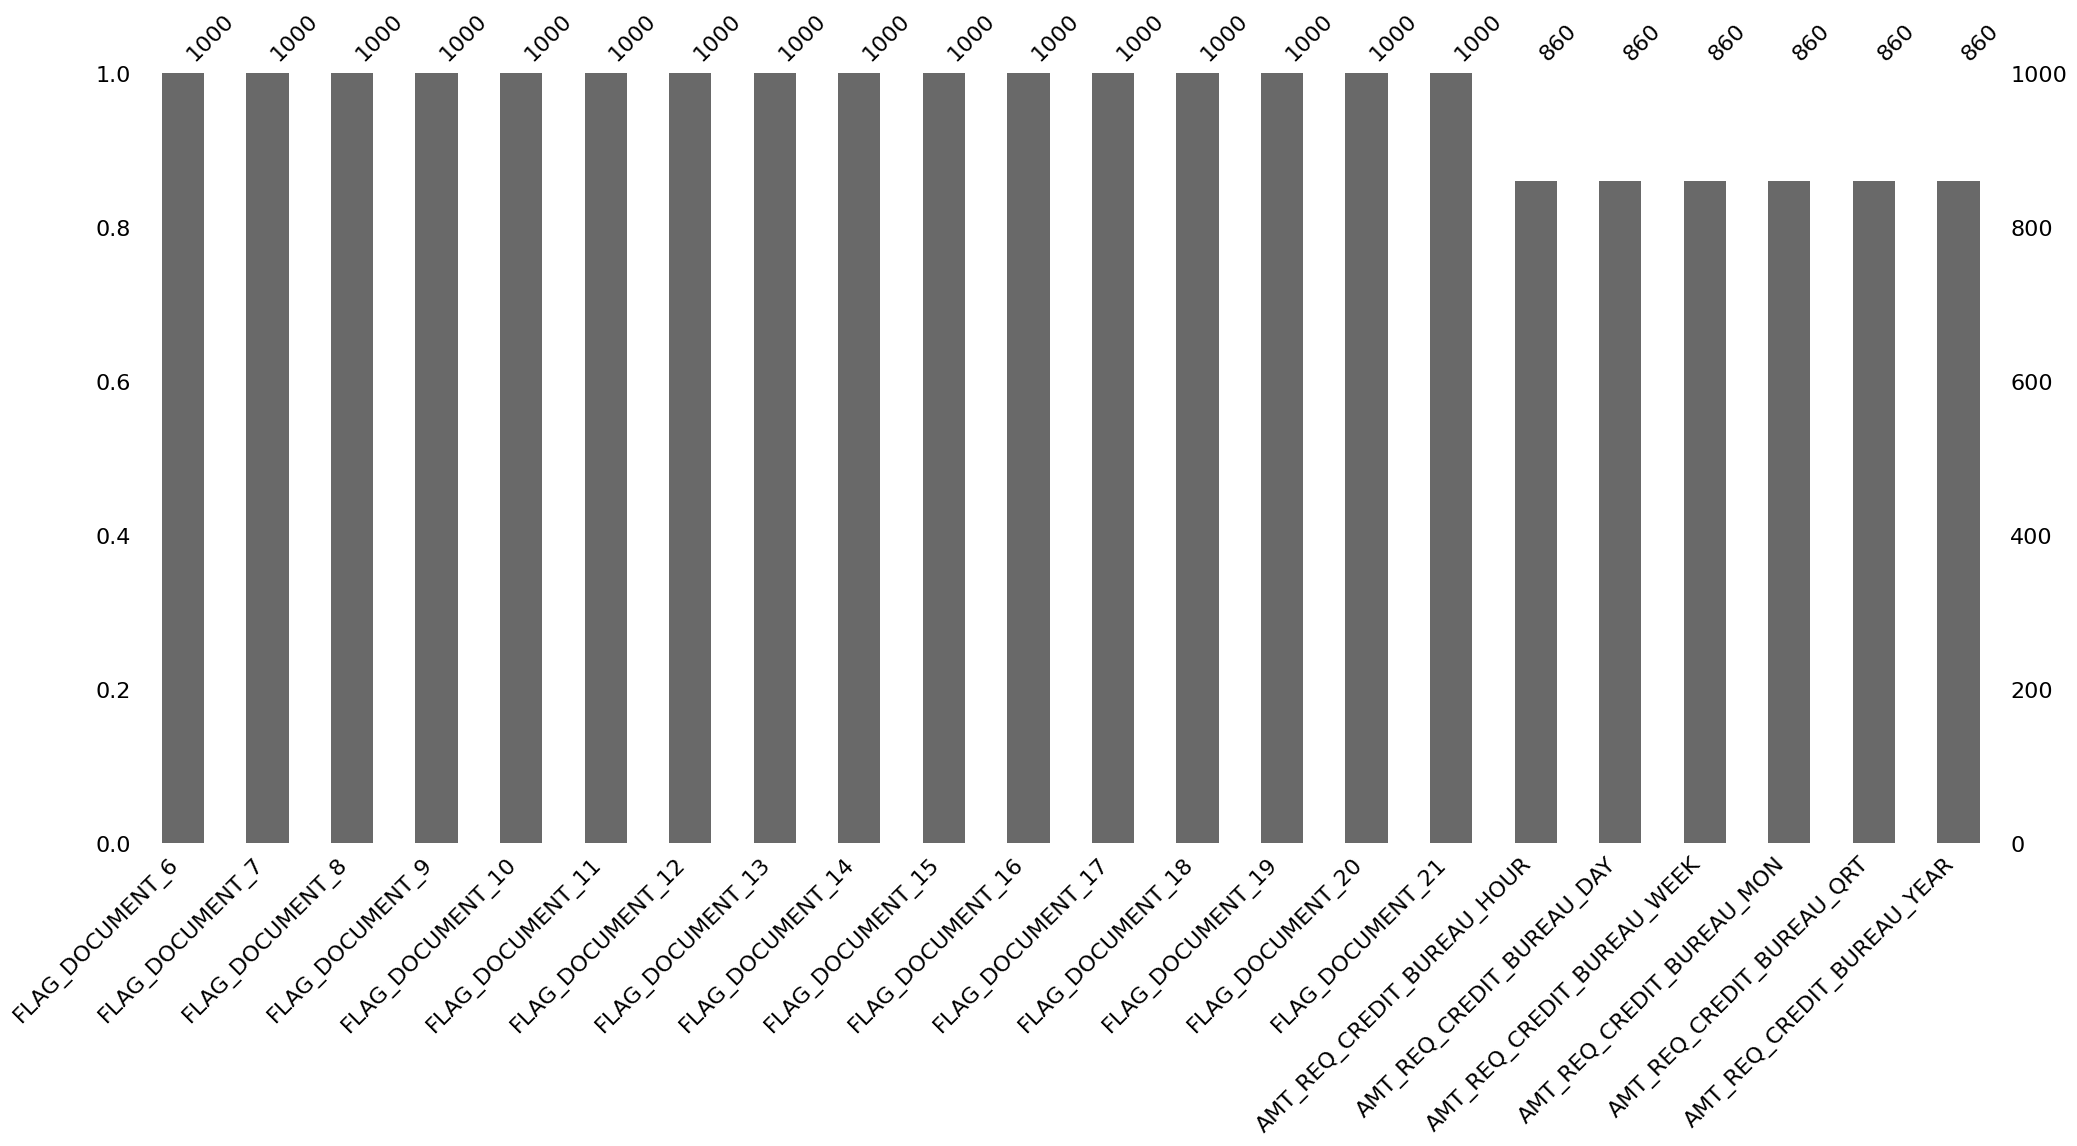

In [26]:
msno.bar(df_app.iloc[:, 100:].sample(1000))

In [27]:
df_app['SK_ID_CURR'].duplicated().sum()

0

## EDA

### Analyse de Target

[Text(0, 0, '91.93 %'), Text(0, 0, '8.07 %')]

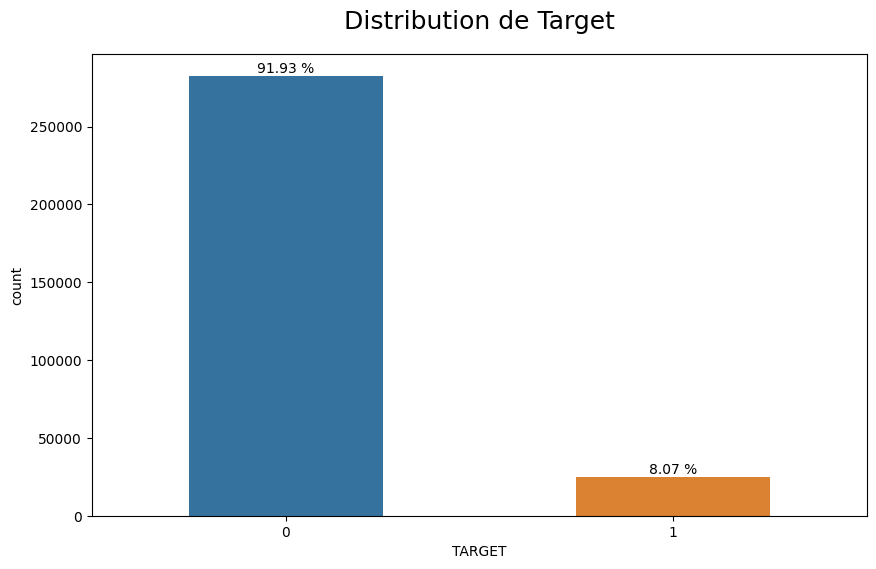

In [28]:
# Affichage de la distribution de notre cible
# 0 : pas de problème de remboursement du crédit
# 1 : difficulté a rembourser

fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

Distribution des classes déséquilibrées

[Text(0, 0, '61.23 %'), Text(0, 0, '4.61 %')]

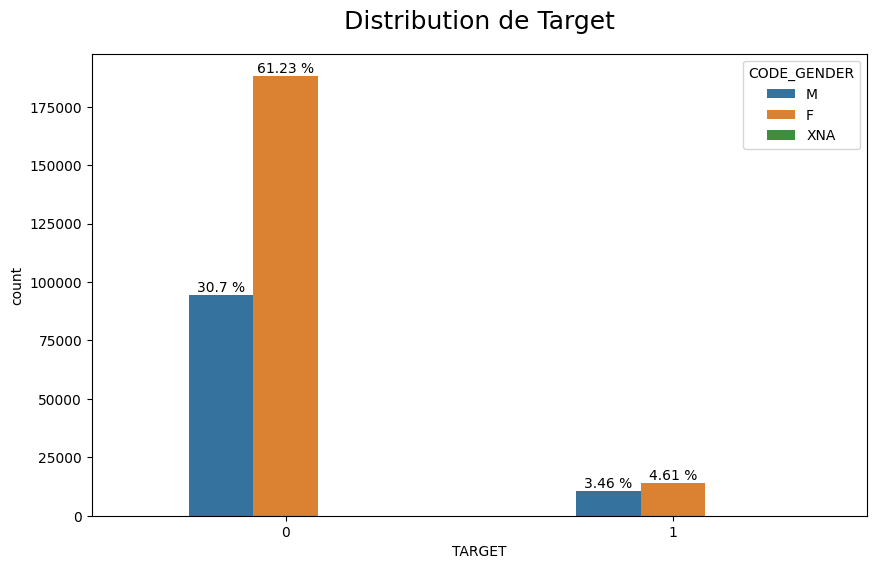

In [29]:
fig, ax = plt.subplots(figsize = (10,6))

data = df_app.copy()

sns.countplot(ax = ax, data = data, x='TARGET', hue='CODE_GENDER', width = 0.5, saturation = 0.7)

ax.set_title('Distribution de Target', fontsize = 18, pad = 18)

bar_lbl = ax.containers[0].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[0], labels = bar_lbl)

bar_lbl = ax.containers[1].datavalues*100 / df_app.shape[0]
bar_lbl = [str(round(x, 2)) + ' %' for x in bar_lbl]
ax.bar_label(ax.containers[1], labels = bar_lbl)

In [30]:
df_app.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

## Feature Engineering

In [31]:
num_rows = 100000
nan_as_category = False

start = time.time()
df_to_export = utils.application_train_test(num_rows)

bureau = utils.bureau_and_balance(num_rows, nan_as_category)
print("Bureau df shape:", bureau.shape)
df_to_export = df_to_export.join(bureau, how='left', on='SK_ID_CURR')


prev = utils.previous_applications(num_rows, nan_as_category)
print("Previous applications df shape:", prev.shape)
df_to_export = df_to_export.join(prev, how='left', on='SK_ID_CURR')
del prev


pos = utils.pos_cash(num_rows, nan_as_category)
print("Pos-cash balance df shape:", pos.shape)
df_to_export = df_to_export.join(pos, how='left', on='SK_ID_CURR')
del pos

ins = utils.installments_payments(num_rows, nan_as_category)
print("Installments payments df shape:", ins.shape)
df_to_export = df_to_export.join(ins, how='left', on='SK_ID_CURR')
del ins

cc = utils.credit_card_balance(num_rows, nan_as_category)
print("Credit card balance df shape:", cc.shape)
df_to_export = df_to_export.join(cc, how='left', on='SK_ID_CURR')
del cc

# drop de qqs rows avec des valeurs np.inf
df_to_export.drop(df_to_export.iloc[df_to_export.values==np.inf].index, 
                  inplace=True)

# drop des colonnes avec plus de 80% de valeurs manquantes
# (threshold à ajuster plus tard)
df_to_export.dropna(thresh=df_to_export.shape[0]*0.2, axis=1, inplace=True)


tps_traitement = np.round(time.time() - start, 2)

print('--------------------------')
print('Temps total du feature engineering: {}s'.format(tps_traitement))
print('Dataframe finale shape:', df_to_export.shape)

if num_rows:
    print(df_to_export['TARGET'].value_counts(normalize=True))

Train samples: 100000
Bureau df shape: (23121, 109)
Previous applications df shape: (79977, 247)
Pos-cash balance df shape: (77469, 15)
Installments payments df shape: (48591, 26)
Credit card balance df shape: (53383, 131)
--------------------------
Temps total du feature engineering: 6.55s
Dataframe finale shape: (99996, 458)
0    0.919067
1    0.080933
Name: TARGET, dtype: float64


## Feature Selection

In [39]:
df = df_to_export.copy()

X = df.drop(['TARGET'], axis=1)

p = 0.99
th = p*(1 - p)
var_selector = VarianceThreshold(th)
var_selector.set_output(transform='pandas')
X_reduced = var_selector.fit_transform(X)

X_reduced.shape

(99996, 270)

In [40]:
X_reduced.fillna(0, inplace=True)
y = df['TARGET']

selector = SelectKBest(mutual_info_classif, k=100)
selector.set_output(transform='pandas')
X_test = selector.fit_transform(X_reduced, y)

print(X_test.shape)

(99996, 100)


Text(0.5, 1.0, 'Feature importance basé sur mutual_info_classif')

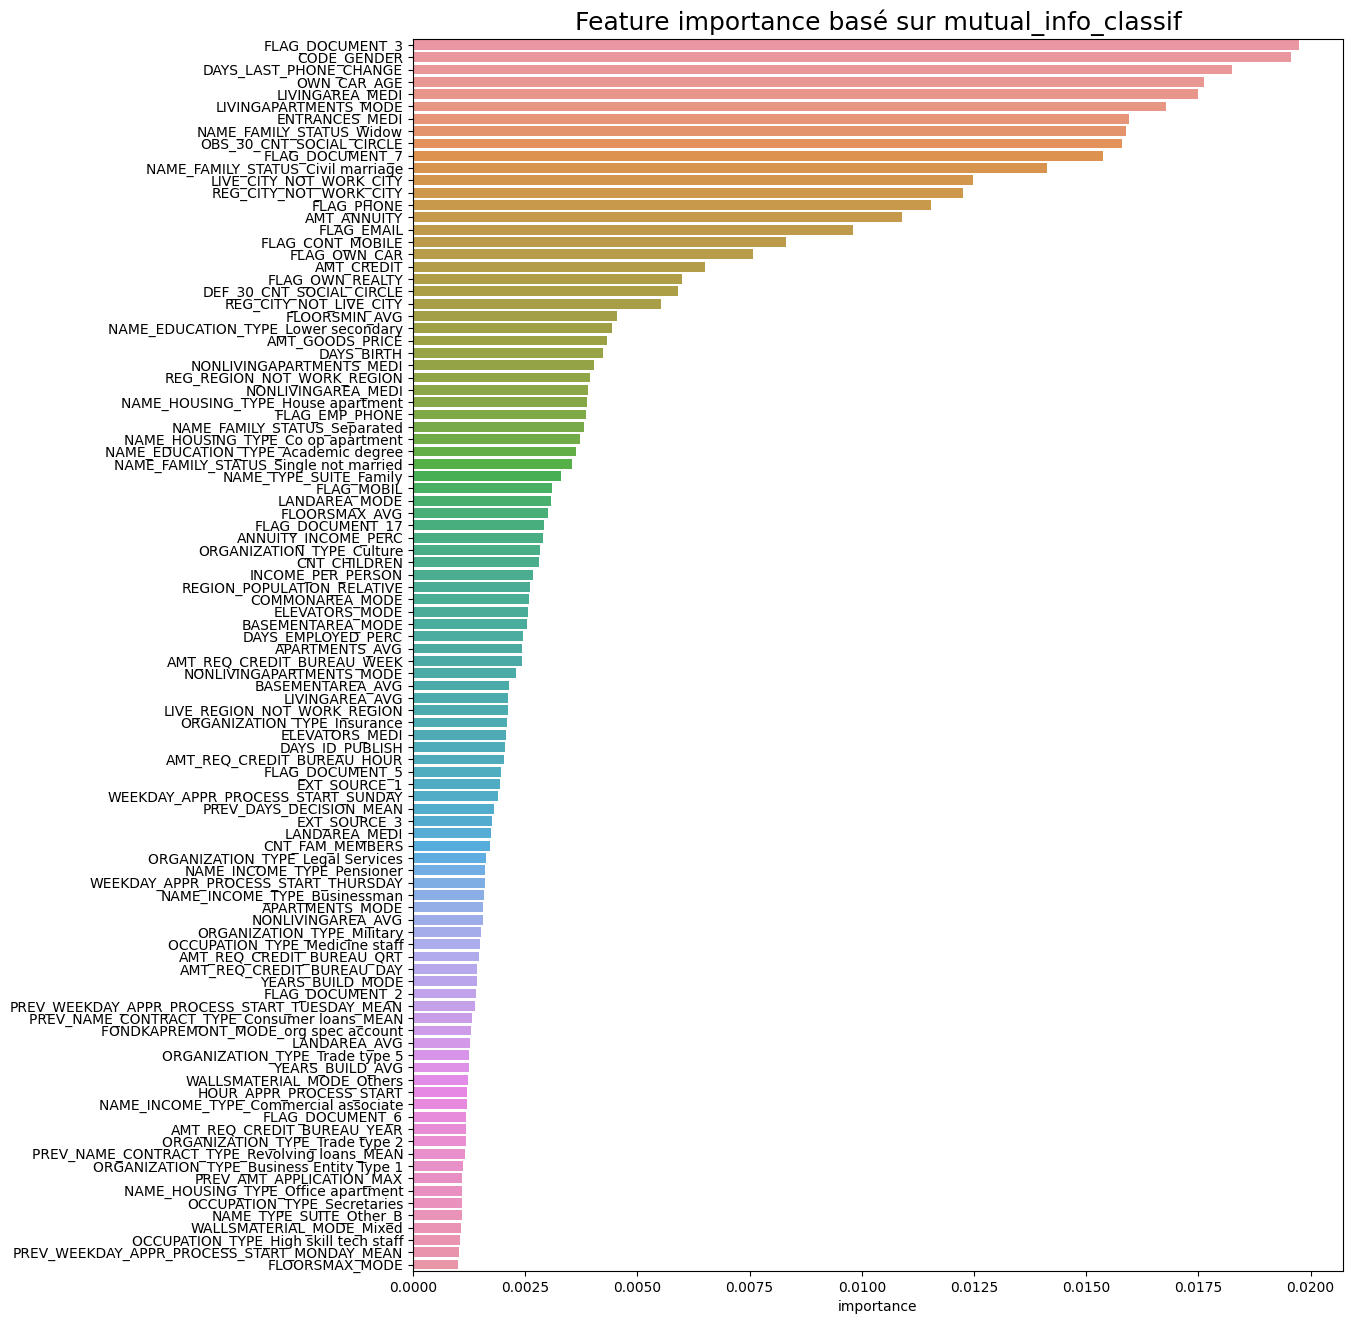

In [41]:
idx = np.argsort(-1*selector.scores_)
d = {'feature' : X.columns[idx],
     'importance' : selector.scores_[idx]
    }
best_features = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(x="importance", y="feature", data=best_features.iloc[:100,:])
ax.set_ylabel(None)
ax.set_title('Feature importance basé sur mutual_info_classif',  fontsize = 18)

In [42]:
X_test = X_test.reindex(columns=best_features.iloc[:100,0].values)

In [43]:
corr_matrix = X_test.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print('There are %d columns to remove.' % (len(to_drop)))
print(to_drop)

final_feats = [col for col in X_test.columns if col not in to_drop]
print("Nombre de features retenues au final : {}".format(len(final_feats)))

There are 5 columns to remove.
['AMT_GOODS_PRICE', 'APARTMENTS_AVG', 'LIVINGAREA_AVG', 'NAME_INCOME_TYPE_Pensioner', 'FLOORSMAX_MODE']
Nombre de features retenues au final : 95


In [44]:
final_feats = ['SK_ID_CURR', 'TARGET'] + final_feats 
df_to_export = df_to_export[final_feats]
df_to_export.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 97 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   SK_ID_CURR                                    99996 non-null  int64  
 1   TARGET                                        99996 non-null  int64  
 2   FLAG_DOCUMENT_3                               99996 non-null  int64  
 3   CODE_GENDER                                   99996 non-null  int64  
 4   DAYS_LAST_PHONE_CHANGE                        99995 non-null  float64
 5   OWN_CAR_AGE                                   33979 non-null  float64
 6   LIVINGAREA_MEDI                               49847 non-null  float64
 7   LIVINGAPARTMENTS_MODE                         31734 non-null  float64
 8   ENTRANCES_MEDI                                49717 non-null  float64
 9   NAME_FAMILY_STATUS_Widow                      99996 non-null 

In [45]:
df_to_export.to_csv('final_features.csv', index=False)

---